In [1]:
import torch
import numpy as np
import scanpy as sc
from datasets import load_from_disk
from geneformer.pretrainer import token_dictionary
from transformers import BertForSequenceClassification

In [22]:
def trunc_and_pad_input_id(x, max_len=2048, pad_token_id=0):
    input_id = torch.tensor(x['input_ids'])
    length = x['length']
    input_id = input_id[0:max_len] if length > max_len else input_id # 截断
    input_ids_pad = torch.nn.functional.pad(input_id, 
                                            pad=(0, max_len - input_id.numel()), 
                                            mode='constant', 
                                            value=pad_token_id)
    return {'input_ids_pad': input_ids_pad}

def collate_fn(data):
    input_ids = [np.array(i['input_ids_pad']) for i in data]
    # 转换为tensor
    input_ids = torch.tensor(np.array(input_ids), dtype=torch.int32)
    attention_mask = (input_ids > 0).to(torch.int32)
    return input_ids, attention_mask

In [3]:
## Load model
model = BertForSequenceClassification.from_pretrained(
    "./finetuned-models/231203_geneformer_CellClassifier_iPSC_L2048_B12_LR5e-05_LSlinear_WU500_E2_Oadamw_F0/checkpoint-10715/", 
    output_hidden_states=True, 
    output_attentions=False)
model.eval()
None

In [5]:
data = load_from_disk('tokenize-data/iPSC_GSE118258_2.dataset/')
data = data.filter(lambda x: x['time_point'] in ['D0', 'D16_positive'])
data = data.map(trunc_and_pad_input_id, num_proc=4)
## generate the gene_list
data1 = data.filter(lambda x: x['time_point'] == 'D0', num_proc=4)
data2 = data.filter(lambda x: x['time_point'] == 'D16_positive', num_proc=4)

Filter:   0%|          | 0/32138 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/9737 [00:00<?, ? examples/s]

/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Filter (num_proc=4):   0%|          | 0/9737 [00:00<?, ? examples/s]

/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table

Filter (num_proc=4):   0%|          | 0/9737 [00:00<?, ? examples/s]

/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table

In [6]:
import itertools

In [10]:
set(itertools.chain.from_iterable([[1,2,3],[3,4,5]]))

{1, 2, 3, 4, 5}

In [13]:
[1,2,3,4,5,6][0:-4]

[1, 2]

In [16]:
import itertools
genes_origin = [x[0:-4] for x in data1['input_ids_pad']]
genes_origin = set(itertools.chain.from_iterable(genes_origin))
genes_target = set(itertools.chain.from_iterable(data2['input_ids']))
genes = list(genes_origin & genes_target)
len(genes)

11286

In [20]:
genes # tokens
token2idx = {genes[i]:i for i in range(len(genes))} # token to position
token2idx
None

## 1. Gene embeddings in target state

In [23]:
loader = torch.utils.data.DataLoader(
    data2,
    batch_size=10, ##适当调低batch_size可以降低对显存的占用，10：6G显存
    drop_last=False, 
    shuffle=False, 
    num_workers=4, 
    collate_fn=collate_fn
)

In [50]:
# 计算每种状态的细胞中的gene embeddings的总和和基因的频数
def calculate_cumulative_gene_embeddings(gene_embeddings, gene_freqs, token2idx, input_ids, hidden_state):
    batch_size = input_ids.shape[0] # 10
    for bs in range(batch_size):
        _input_ids = input_ids[bs] # shape [2048]
        _hidden_state = hidden_state[bs] # shape [2048, 256]
        
        idx1 = [i.item() in token2idx for i in _input_ids] # True, False
        idx2 = [token2idx[i.item()] for i in _input_ids if i.item() in token2idx]
        gene_embeddings[idx2, :] += _hidden_state[idx1, :].to('cpu')
        gene_freqs[idx2] += 1
    return gene_embeddings, gene_freqs

In [30]:
%%time
from tqdm import tqdm

## 初始化一个gene_embeddings，记录gene embedding的和
gene_embeddings = torch.zeros(len(genes), 256)
gene_embeddings.shape
## 初始化一个gene_freqs，记录基因出现的频数
gene_freqs = torch.zeros(len(genes))
gene_freqs.shape

## 如果你有GPU，那么使用如下代码进行推理
device = torch.device('cuda', 0)
if model.device != device:
    model = model.to(device)
for i, (input_ids, attention_mask) in tqdm(enumerate(loader), total = len(loader)):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    hidden_state = outputs.hidden_states[-1] ## fine-tuned model, set to last layer(-1) # [10, 2048, 256]
    gene_embeddings, gene_freqs = calculate_cumulative_gene_embeddings(gene_embeddings, gene_freqs, token2idx, input_ids, hidden_state)

100%|█████████████████████████████████████████████████████| 266/266 [05:52<00:00,  1.33s/it]

CPU times: user 9min 47s, sys: 29.9 s, total: 10min 17s
Wall time: 5min 52s


In [45]:
gene_embeddings

tensor([[-1.4300e+03,  3.1692e+03,  4.5006e+02,  ...,  2.9930e+02,
         -2.7307e+01, -5.0046e+03],
        [-1.6318e+03,  3.7743e+03,  1.1562e+03,  ...,  1.4589e+03,
          8.1491e+02, -5.3735e+03],
        [ 1.4810e-01, -8.2263e-01,  5.1659e-01,  ..., -5.6015e-01,
         -1.7136e-02, -1.3153e+00],
        ...,
        [-2.5341e+01,  3.2972e+01,  1.5658e+01,  ..., -2.4092e+01,
          1.6684e+01, -6.1241e+01],
        [-2.8709e+00,  7.7010e+00,  2.0724e+00,  ..., -3.6200e+00,
          5.7827e-01, -7.6242e+00],
        [-5.6709e+00,  9.1097e+00,  5.8586e+00,  ..., -8.5117e-01,
         -8.1972e-01, -1.2503e+01]])

In [41]:
gene_freqs = gene_freqs.reshape(gene_embeddings.shape[0], 1)
average_gene_embeddings = gene_embeddings / gene_freqs 
average_gene_embeddings.shape

torch.Size([11286, 256])

In [47]:
! mkdir isp1203/iPSC_GSE118258

In [49]:
torch.save(average_gene_embeddings, 'isp1203/iPSC_GSE118258/gene_embeddings_target.pt')

## 2. Gene embeddings in original state

In [51]:
loader = torch.utils.data.DataLoader(
    data1,
    batch_size=10, ##适当调低batch_size可以降低对显存的占用，10：6G显存
    drop_last=False, 
    shuffle=False, 
    num_workers=4, 
    collate_fn=collate_fn
)

In [52]:
%%time
from tqdm import tqdm

## 初始化一个gene_embeddings，记录gene embedding的和
gene_embeddings = torch.zeros(len(genes), 256)
gene_embeddings.shape
## 初始化一个gene_freqs，记录基因出现的频数
gene_freqs = torch.zeros(len(genes))
gene_freqs.shape

## 如果你有GPU，那么使用如下代码进行推理
device = torch.device('cuda', 0)
if model.device != device:
    model = model.to(device)
for i, (input_ids, attention_mask) in tqdm(enumerate(loader), total = len(loader)):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    hidden_state = outputs.hidden_states[-1] ## fine-tuned model, set to last layer(-1) # [10, 2048, 256]
    gene_embeddings, gene_freqs = calculate_cumulative_gene_embeddings(gene_embeddings, gene_freqs, token2idx, input_ids, hidden_state)

100%|█████████████████████████████████████████████████████| 708/708 [16:09<00:00,  1.37s/it]

CPU times: user 26min 41s, sys: 1min 18s, total: 27min 59s
Wall time: 16min 9s


In [53]:
gene_freqs = gene_freqs.reshape(gene_embeddings.shape[0], 1)
average_gene_embeddings = gene_embeddings / gene_freqs 
average_gene_embeddings.shape

torch.Size([11286, 256])

In [54]:
torch.save(average_gene_embeddings, 'isp1203/iPSC_GSE118258/gene_embeddings_origin.pt')

## 3. Gene embeddings in OSKM+original state

In [55]:
def overexpress(x, id_list):
    input_id = x['input_ids_pad']
    input_id = [x for x in input_id if x not in id_list]
    input_id = id_list + input_id
    return {'input_ids_perturbed': input_id[0:2048]}

def collate_fn2(data):
    input_ids = [np.array(i['input_ids_perturbed']) for i in data]
    # 转换为tensor
    input_ids = torch.tensor(np.array(input_ids), dtype=torch.int32)
    attention_mask = (input_ids > 0).to(torch.int32)
    return input_ids, attention_mask

In [56]:
## OCT4(POU5F1) ENSG00000204531
## SOX2         ENSG00000181449
## KLF4         ENSG00000136826
## MYC          ENSG00000136997
target_genes = ['ENSG00000204531', 'ENSG00000181449', 'ENSG00000136826', 'ENSG00000136997']
target_ids = [token_dictionary[i] for i in target_genes]
target_ids

[17679, 14712, 7301, 7352]

In [57]:
data1 = data1.map(overexpress, num_proc=4, fn_kwargs={'id_list': target_ids})

Map (num_proc=4):   0%|          | 0/7079 [00:00<?, ? examples/s]

/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table

In [58]:
input_ids, attention_mask = collate_fn2(data1.select(range(5)))
[i[0:10] for i in input_ids]

[tensor([17679, 14712,  7301,  7352,  5592, 20053, 16725,  5368,  2183,  5401],
        dtype=torch.int32),
 tensor([17679, 14712,  7301,  7352, 20053,  3481, 17126,  7923,  2183, 11143],
        dtype=torch.int32),
 tensor([17679, 14712,  7301,  7352,  1720,  2183, 17126, 12172,  4686,  4415],
        dtype=torch.int32),
 tensor([17679, 14712,  7301,  7352,  7923, 14947,  2183, 17126, 20053,  5298],
        dtype=torch.int32),
 tensor([17679, 14712,  7301,  7352, 20053, 16725, 11143,  2183,  5368,  7923],
        dtype=torch.int32)]

In [59]:
loader = torch.utils.data.DataLoader(
    data1,
    batch_size=10, ##适当调低batch_size可以降低对显存的占用，10：6G显存
    drop_last=False, 
    shuffle=False, 
    num_workers=4, 
    collate_fn=collate_fn2
)

In [60]:
%%time
from tqdm import tqdm

## 初始化一个gene_embeddings，记录gene embedding的和
gene_embeddings = torch.zeros(len(genes), 256)
gene_embeddings.shape
## 初始化一个gene_freqs，记录基因出现的频数
gene_freqs = torch.zeros(len(genes))
gene_freqs.shape

## 如果你有GPU，那么使用如下代码进行推理
device = torch.device('cuda', 0)
if model.device != device:
    model = model.to(device)
for i, (input_ids, attention_mask) in tqdm(enumerate(loader), total = len(loader)):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    hidden_state = outputs.hidden_states[-1] ## fine-tuned model, set to last layer(-1) # [10, 2048, 256]
    gene_embeddings, gene_freqs = calculate_cumulative_gene_embeddings(gene_embeddings, gene_freqs, token2idx, input_ids, hidden_state)

100%|█████████████████████████████████████████████████████| 708/708 [16:02<00:00,  1.36s/it]

CPU times: user 26min 40s, sys: 1min 19s, total: 27min 59s
Wall time: 16min 2s


In [61]:
gene_freqs = gene_freqs.reshape(gene_embeddings.shape[0], 1)
average_gene_embeddings = gene_embeddings / gene_freqs 
average_gene_embeddings.shape

torch.Size([11286, 256])

In [62]:
torch.save(average_gene_embeddings, 'isp1203/iPSC_GSE118258/gene_embeddings_origin_OSKM.pt')

## 4. Gene embeddings in RANDOM+original state

In [78]:
import random
token_list = list(token_dictionary.values())
random.seed(1024)
random.shuffle(token_list)
random_list = [x for x in token_list[0:200] if x not in target_ids][0:4]
random_list

[15509, 14750, 16241, 22184]

In [80]:
nekot_dict = {v:k for k,v in token_dictionary.items()}

In [82]:
[nekot_dict[x] for x in random_list]

['ENSG00000185220', 'ENSG00000181718', 'ENSG00000188620', 'ENSG00000264771']

In [83]:
data1 = data1.map(overexpress, num_proc=4, fn_kwargs={'id_list': random_list})

Map (num_proc=4):   0%|          | 0/7079 [00:00<?, ? examples/s]

/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table

In [84]:
input_ids, attention_mask = collate_fn2(data1.select(range(5)))
[i[0:10] for i in input_ids]

[tensor([15509, 14750, 16241, 22184,  5592, 20053, 16725,  5368,  2183,  5401],
        dtype=torch.int32),
 tensor([15509, 14750, 16241, 22184, 20053,  3481, 17126,  7923,  2183, 11143],
        dtype=torch.int32),
 tensor([15509, 14750, 16241, 22184,  1720,  2183, 17126, 12172,  4686,  4415],
        dtype=torch.int32),
 tensor([15509, 14750, 16241, 22184,  7923, 14947,  2183, 17126, 20053,  5298],
        dtype=torch.int32),
 tensor([15509, 14750, 16241, 22184, 20053, 16725, 11143,  2183,  5368,  7923],
        dtype=torch.int32)]

In [86]:
loader = torch.utils.data.DataLoader(
    data1,
    batch_size=10, ##适当调低batch_size可以降低对显存的占用，10：6G显存
    drop_last=False, 
    shuffle=False, 
    num_workers=4, 
    collate_fn=collate_fn2
)

In [87]:
%%time
from tqdm import tqdm

## 初始化一个gene_embeddings，记录gene embedding的和
gene_embeddings = torch.zeros(len(genes), 256)
gene_embeddings.shape
## 初始化一个gene_freqs，记录基因出现的频数
gene_freqs = torch.zeros(len(genes))
gene_freqs.shape

## 如果你有GPU，那么使用如下代码进行推理
device = torch.device('cuda', 0)
if model.device != device:
    model = model.to(device)
for i, (input_ids, attention_mask) in tqdm(enumerate(loader), total = len(loader)):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    hidden_state = outputs.hidden_states[-1] ## fine-tuned model, set to last layer(-1) # [10, 2048, 256]
    gene_embeddings, gene_freqs = calculate_cumulative_gene_embeddings(gene_embeddings, gene_freqs, token2idx, input_ids, hidden_state)

100%|█████████████████████████████████████████████████████| 708/708 [16:11<00:00,  1.37s/it]

CPU times: user 26min 40s, sys: 1min 17s, total: 27min 57s
Wall time: 16min 11s


In [88]:
gene_freqs = gene_freqs.reshape(gene_embeddings.shape[0], 1)
average_gene_embeddings = gene_embeddings / gene_freqs 
average_gene_embeddings.shape

torch.Size([11286, 256])

In [89]:
torch.save(average_gene_embeddings, 'isp1203/iPSC_GSE118258/gene_embeddings_origin_random.pt')

## 5. 计算扰动的效应

In [90]:
gene_embeddings_origin = torch.load('isp1203/iPSC_GSE118258/gene_embeddings_origin.pt')
gene_embeddings_target = torch.load('isp1203/iPSC_GSE118258/gene_embeddings_target.pt')
gene_embeddings_test   = torch.load('isp1203/iPSC_GSE118258/gene_embeddings_origin_OSKM.pt')
gene_embeddings_random = torch.load('isp1203/iPSC_GSE118258/gene_embeddings_origin_random.pt')

In [91]:
gene_embeddings_origin.shape, 
gene_embeddings_target.shape, 
gene_embeddings_test.shape, 
gene_embeddings_random.shape, 

(torch.Size([11286, 256]),)

In [92]:
sim1 = torch.cosine_similarity(gene_embeddings_origin, gene_embeddings_target)
sim2 = torch.cosine_similarity(gene_embeddings_test, gene_embeddings_target)
sim3 = torch.cosine_similarity(gene_embeddings_random, gene_embeddings_target)

In [95]:
test_effect = sim2 - sim1
random_effect = sim3 - sim1

/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

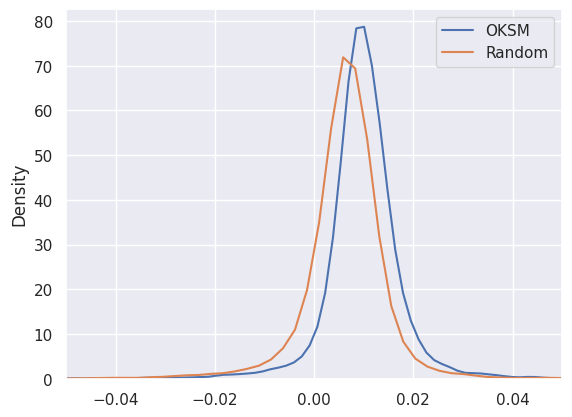

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.kdeplot(test_effect.numpy(), label='OKSM')
sns.kdeplot(random_effect.numpy(), label='Random')

# 添加图例
plt.legend()
plt.xlim(-0.05, 0.05)

# 显示图形
plt.show()